In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings

In [2]:
# Create order_period column based on order time
def get_order_period(order_time):
    if order_time >= pd.to_datetime('06:00:00').time() and order_time < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif order_time >= pd.to_datetime('12:00:00').time() and order_time < pd.to_datetime('18:00:00').time():
        return 'Afternoon'
    elif order_time >= pd.to_datetime('18:00:00').time() and order_time <= pd.to_datetime('23:59:59').time():
        return 'Night'
    else:
        return 'Night'
    
def get_week_of_month(date):
    first_day = date.replace(day=1)
    day_of_month = date.day
    adjusted_dom = day_of_month + first_day.weekday()
    return (adjusted_dom - 1) // 7 + 1

In [3]:
data = pd.read_csv('data\delhi_data.csv')
data.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Jayit Ghosh\AppData\Local\Temp\ipykernel_9696\2443955058.py:1: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('data\delhi_data.csv')


,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


Feature Engineering

In [4]:
df = data.copy()

# Convert 'Order Date and Time' and 'Delivery Date and Time' to datetime format
df['Order Date and Time'] = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time'] = pd.to_datetime(df['Delivery Date and Time'])

# Extracting separate columns for order and delivery date and time
df['Order Date'] = df['Order Date and Time'].dt.date
df['Order Time'] = df['Order Date and Time'].dt.time
df['Delivery Date'] = df['Delivery Date and Time'].dt.date
df['Delivery Time'] = df['Delivery Date and Time'].dt.time

# Extract numerical value of discount from 'Discounts and Offers' column
df['Discount'] = df['Discounts and Offers'].str.extract(r"(\d+\.?\d*)").astype('Int8').fillna(0)

df['Order Period'] = df['Order Time'].apply(get_order_period)
df['Order Week'] = df['Order Date'].apply(get_week_of_month)

# Convert 'Order Week of Month' to an ordered categorical type
df['Order Week'] = df['Order Date and Time'].apply(lambda x: get_week_of_month(x))
week_categories = [1, 2, 3, 4, 5]
df['Order Week'] = pd.Categorical(df['Order Week'], categories=week_categories, ordered=True)

# Replace values in 'Payment Method' column
df['Payment Method'] = df['Payment Method'].replace({
    'Cash on Delivery': 'COD',
    'Credit Card': 'CC',
    'Digital Wallet': 'UPI'
})

df.sample(6)

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks,Order Date,Order Time,Delivery Date,Delivery Time,Discount,Order Period,Order Week
529,530,C5268,R2697,2024-02-04 18:17:27,2024-02-04 18:51:27,1815,50,COD,15% New User,114,33,0,2024-02-04,18:17:27,2024-02-04,18:51:27,15,Night,1
140,141,C7776,R2933,2024-02-01 15:05:19,2024-02-01 15:37:19,1845,50,CC,10%,91,46,0,2024-02-01,15:05:19,2024-02-01,15:37:19,10,Afternoon,1
626,627,C6997,R2523,2024-02-01 13:13:36,2024-02-01 13:47:36,1617,0,UPI,10%,180,32,0,2024-02-01,13:13:36,2024-02-01,13:47:36,10,Afternoon,1
758,759,C7168,R2955,2024-01-08 05:01:33,2024-01-08 05:48:33,410,20,COD,10%,129,18,0,2024-01-08,05:01:33,2024-01-08,05:48:33,10,Night,2
901,902,C1793,R2722,2024-01-04 08:49:58,2024-01-04 09:42:58,899,30,UPI,5% on App,84,48,0,2024-01-04,08:49:58,2024-01-04,09:42:58,5,Morning,1
40,41,C8513,R2095,2024-01-02 01:38:44,2024-01-02 02:22:44,430,50,UPI,5% on App,188,45,150,2024-01-02,01:38:44,2024-01-02,02:22:44,5,Night,1


In [5]:

## Top 5 valued Customers
cust_spend = df.groupby(['Customer ID']).agg({'Order Value':'sum'}).reset_index().sort_values(by='Order Value',ascending=False)
cust_spend.head()

,Customer ID,Order Value
730,C7949,3870
282,C3832,3768
770,C8266,3703
457,C5555,3664
406,C5146,3361


Customer wise analysis

In [6]:
import datetime as dt

In [7]:
cust_id = 'C7938'

In [8]:
customer_metrics = pd.DataFrame(columns=['Metric','Value'])
customer_metrics = customer_metrics.iloc[0:0]

In [9]:
# Assuming 'df' is the dfset containing customer information
current_date = dt.datetime.now()

def calculate_recency(customer_id):
    # global data 
    current_date = dt.datetime.now()
    customer_data = df[df['Customer ID'] == customer_id]
    if not customer_data.empty:
        last_order_date = customer_data['Order Date and Time'].max()
        recency = (current_date - last_order_date).days
        return pd.DataFrame({'Metric': ['Recency'], 'Value': [recency]})
    return None

recency_df = calculate_recency(cust_id)
recency_df

,Metric,Value
0,Recency,264


In [10]:
##  Function to calculate Average Order Value (AOV)
def calculate_average_order_value(customer_id):
    
    customer_df = df[df['Customer ID'] == customer_id]
    
    if not customer_df.empty:
        # Calculate total value of orders (monetary) and frequency
        monetary = customer_df['Order Value'].sum()
        frequency = len(customer_df)
        
        # Calculate Average Order Value
        aov = monetary / frequency
        return pd.DataFrame({'Metric': ['Average Order Value'], 'Value': [round(aov,2)]})
    
    return None

aov = calculate_average_order_value(cust_id)
aov

,Metric,Value
0,Average Order Value,760.33


In [11]:
def calculate_preferred_order_period(customer_id):
    
    customer_data = df[df['Customer ID'] == customer_id]
    if not customer_data.empty:
        preferred_period = customer_data['Order Period'].mode()[0]
        return pd.DataFrame({'Metric': ['Preferred Order Period'], 'Value': [preferred_period]})
    return None

preferred_order_period_df = calculate_preferred_order_period(cust_id)



In [12]:
def calculate_average_days_between_orders(customer_id):
    # global data
    customer_data = df[df['Customer ID'] == customer_id].sort_values(by='Order Date and Time')
    if len(customer_data) > 1:
        customer_data['Time Difference'] = customer_data['Order Date and Time'].diff().dt.days
        avg_time_between_orders = customer_data['Time Difference'].mean()
        return pd.DataFrame({'Metric': ['Average Time Between Orders'], 'Value': [avg_time_between_orders]})
    return None

# Example usage:
average_days_between_orders_df = calculate_average_days_between_orders(cust_id)
print(average_days_between_orders_df)


                        Metric  Value
0  Average Time Between Orders    7.0


In [13]:
def calculate_discount_usage_rate(customer_id):
    # global data
    customer_data = df[df['Customer ID'] == customer_id]
    if not customer_data.empty:
        total_orders = len(customer_data)
        discount_orders = len(customer_data[customer_data['Discount'] > 0])
        discount_usage_rate = (discount_orders / total_orders) * 100
        return pd.DataFrame({'Metric': ['Discount Usage Rate'], 'Value': [discount_usage_rate]})
    return None

discount_usage_rate_df = calculate_discount_usage_rate(cust_id)
print(discount_usage_rate_df)

                Metric  Value
0  Discount Usage Rate  100.0


In [14]:
# Function to calculate Preferred Payment Method
def calculate_preferred_payment_method(customer_id):
    # global data
    customer_data = df[df['Customer ID'] == customer_id]
    if not customer_data.empty:
        preferred_payment_method = customer_data['Payment Method'].mode()[0]
        return pd.DataFrame({'Metric': ['Preferred Payment Method'], 'Value': [preferred_payment_method]})
    return None

preferred_payment_method_df = calculate_preferred_payment_method(cust_id)
print(preferred_payment_method_df)


                     Metric Value
0  Preferred Payment Method   COD


In [15]:
df.columns

Index(['Order ID', 'Customer ID', 'Restaurant ID', 'Order Date and Time',
       'Delivery Date and Time', 'Order Value', 'Delivery Fee',
       'Payment Method', 'Discounts and Offers', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks', 'Order Date',
       'Order Time', 'Delivery Date', 'Delivery Time', 'Discount',
       'Order Period', 'Order Week'],
      dtype='object')

In [16]:
# Preferred Payment Method
preferred_payment_method = df.groupby('Customer ID')['Payment Method'].agg(lambda x: x.mode()[0]).reset_index()
preferred_payment_method.rename(columns={'Payment Method': 'Preferred Payment Method'}, inplace=True)
preferred_payment_method


,Customer ID,Preferred Payment Method
0,C1004,COD
1,C1005,UPI
2,C1009,COD
3,C1055,CC
4,C1064,UPI
...,...,...
942,C9945,CC
943,C9958,UPI
944,C9967,UPI
945,C9989,COD


In [17]:
# Order Frequency Segmentation
order_frequency = df.groupby('Customer ID').size().reset_index(name='Order Count')
order_frequency['Frequency Segment'] = pd.cut(order_frequency['Order Count'],
                                              bins=[0, 2, 5, float('inf')],
                                              labels=['Infrequent Orderer', 'Moderate Orderer', 'Frequent Orderer'])

order_frequency


,Customer ID,Order Count,Frequency Segment
0,C1004,1,Infrequent Orderer
1,C1005,1,Infrequent Orderer
2,C1009,2,Infrequent Orderer
3,C1055,1,Infrequent Orderer
4,C1064,1,Infrequent Orderer
...,...,...,...
942,C9945,1,Infrequent Orderer
943,C9958,1,Infrequent Orderer
944,C9967,1,Infrequent Orderer
945,C9989,1,Infrequent Orderer


In [18]:
# Merging Segmentation Data
segmentation_df = pd.merge(preferred_payment_method, order_frequency, on='Customer ID')
segmentation_df.head()

,Customer ID,Preferred Payment Method,Order Count,Frequency Segment
0,C1004,COD,1,Infrequent Orderer
1,C1005,UPI,1,Infrequent Orderer
2,C1009,COD,2,Infrequent Orderer
3,C1055,CC,1,Infrequent Orderer
4,C1064,UPI,1,Infrequent Orderer


Clustering based on spending behaviour

RFM 

In [19]:

reference_date = df['Order Date and Time'].max()

# Customer recency: How many days since their last order
recency = df.groupby('Customer ID')['Order Date and Time'].max().reset_index()
recency['Recency'] = (reference_date - recency['Order Date and Time']).dt.days

# Customer frequency: Total number of orders by each customer
frequency = df.groupby('Customer ID')['Order ID'].count().reset_index()
frequency.columns = ['Customer ID', 'Frequency']

# Customer monetary value: Total spend by each customer
monetary = df.groupby('Customer ID')['Order Value'].sum().reset_index()
monetary.columns = ['Customer ID', 'Monetary']

# Merge recency, frequency, and monetary value into one dataframe
rfm = recency.merge(frequency, on='Customer ID').merge(monetary, on='Customer ID')

rfm.head()

,Customer ID,Order Date and Time,Recency,Frequency,Monetary
0,C1004,2024-02-05 22:45:58,2,1,283
1,C1005,2024-01-13 21:51:28,25,1,705
2,C1009,2024-01-28 02:33:11,10,2,3122
3,C1055,2024-01-18 08:41:11,20,1,1148
4,C1064,2024-02-06 07:52:24,1,1,1538


Standardization

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select the relevant columns for clustering
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert scaled data back to a DataFrame for clarity
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df.head()


,Recency,Frequency,Monetary
0,-1.446438,-0.234298,-1.331275
1,0.671252,-0.234298,-0.654374
2,-0.709850,3.952117,3.222571
3,0.210884,-0.234298,0.056212
4,-1.538512,-0.234298,0.681785


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Data Preparation
def calculate_rfm(df):
    
    # Assume the reference date is the latest order in the dataset
    reference_date = df['Order Date and Time'].max()
    
    # Recency: Time since the last order for each customer
    recency = df.groupby('Customer ID')['Order Date and Time'].max().reset_index()
    recency['Recency'] = (reference_date - recency['Order Date and Time']).dt.days

    # Frequency: Total number of orders per customer
    frequency = df.groupby('Customer ID')['Order ID'].count().reset_index()
    frequency.columns = ['Customer ID', 'Frequency']

    # Monetary: Total amount spent by each customer
    monetary = df.groupby('Customer ID')['Order Value'].sum().reset_index()
    monetary.columns = ['Customer ID', 'Monetary']

    # Merge the RFM metrics into one dataframe
    rfm = recency.merge(frequency, on='Customer ID').merge(monetary, on='Customer ID')
    return rfm

def scale_rfm_features(rfm):
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
    return rfm_scaled


def perform_kmeans_clustering(rfm_scaled, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)
    
    # Return the clusters and the cluster centroids
    return clusters, kmeans.cluster_centers_

def cluster_customers(df):
    # Step 1: Calculate RFM
    rfm = calculate_rfm(df)
    
    # Step 2: Scale the RFM features
    rfm_scaled = scale_rfm_features(rfm)
    
    # Step 3: Perform K-Means with 3 clusters
    clusters, centroids = perform_kmeans_clustering(rfm_scaled, n_clusters=3)
    
    # Add the cluster labels to the original RFM dataframe
    rfm['Cluster'] = clusters
    
    # Return the RFM dataframe with clusters and centroids
    return rfm, centroids


# Perform clustering
rfm_with_clusters, cluster_centroids = cluster_customers(df)

# Inverse transform the scaled centroids to get original values for Recency, Frequency, and Monetary
centroids_original = scaler.inverse_transform(cluster_centroids)

# Convert the centroids back to a DataFrame for easier interpretation
centroids_df = pd.DataFrame(centroids_original, columns=['Recency', 'Frequency', 'Monetary']).apply(lambda x: round(x,0))

# Display the centroids in the original scale
print("Cluster Centroids (Original Scale):\n", centroids_df)


Cluster Centroids (Original Scale):
    Recency  Frequency  Monetary
0      9.0        1.0    1103.0
1     28.0        1.0     979.0
2     11.0        2.0    2364.0


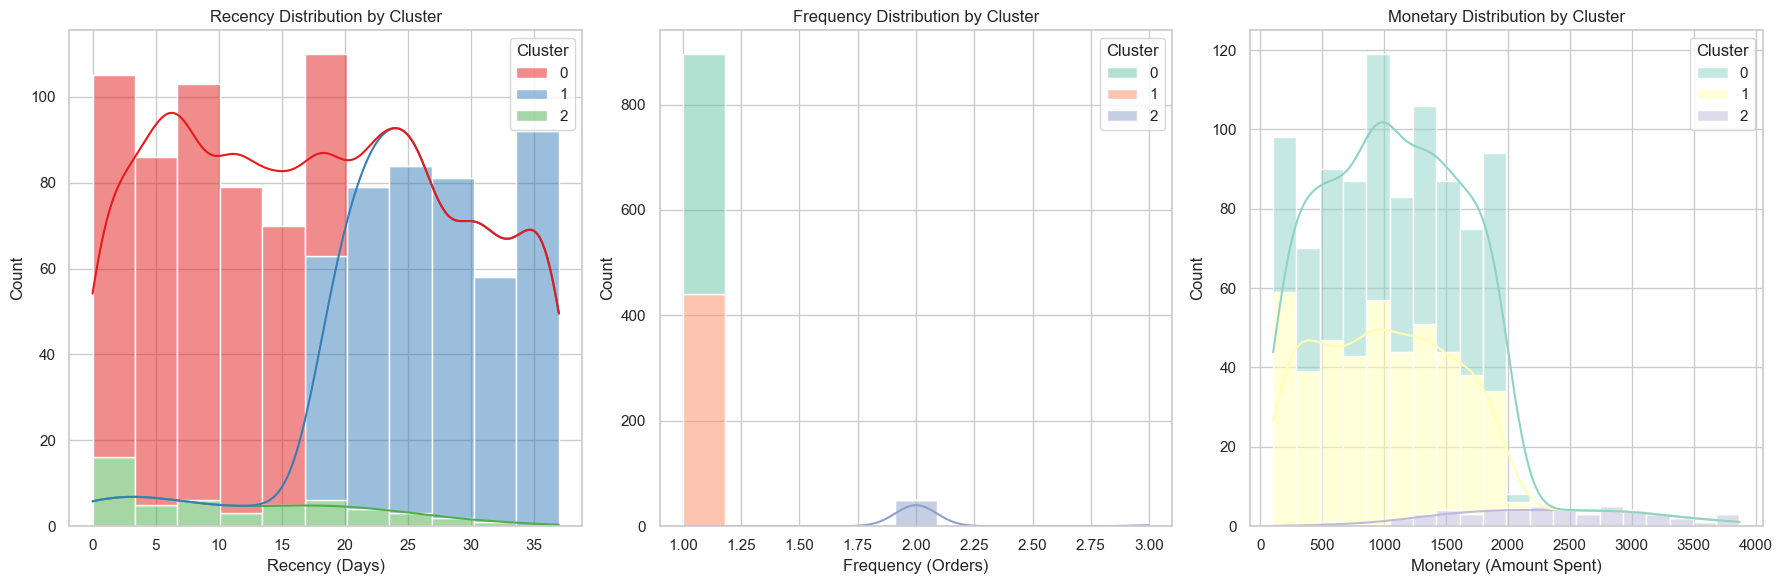

In [23]:
def plot_rfm_distribution(rfm_with_clusters):
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Create a figure with subplots for each RFM metric
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Recency distribution by cluster
    sns.histplot(data=rfm_with_clusters, x='Recency', hue='Cluster', multiple='stack', palette='Set1', ax=axes[0], kde=True)
    axes[0].set_title('Recency Distribution by Cluster')
    axes[0].set_xlabel('Recency (Days)')
    
    # Frequency distribution by cluster
    sns.histplot(data=rfm_with_clusters, x='Frequency', hue='Cluster', multiple='stack', palette='Set2', ax=axes[1], kde=True)
    axes[1].set_title('Frequency Distribution by Cluster')
    axes[1].set_xlabel('Frequency (Orders)')
    
    # Monetary distribution by cluster
    sns.histplot(data=rfm_with_clusters, x='Monetary', hue='Cluster', multiple='stack', palette='Set3', ax=axes[2], kde=True)
    axes[2].set_title('Monetary Distribution by Cluster')
    axes[2].set_xlabel('Monetary (Amount Spent)')
    
    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the RFM distributions
plot_rfm_distribution(rfm_with_clusters)